In [20]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
basepath = f'../results/unbalanced_models'
filename = 'config.json'
with open(os.path.join(basepath, filename), 'r') as f:
    params = json.load(f)

In [22]:
print(params)

{'p_o': 0.01, 'p_p': 0.99, 'lambda_values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'phi_values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'T': 10000, 'n_lobbyists': 20, 'lobbyists_data': {'0': {'m': 1, 'B': 300000, 'c': 1, 'strategies': ['results/unbalanced_models/strategies/300000/strategy_81.txt', 'results/unbalanced_models/strategies/300000/strategy_45.txt', 'results/unbalanced_models/strategies/300000/strategy_85.txt', 'results/unbalanced_models/strategies/300000/strategy_25.txt', 'results/unbalanced_models/strategies/300000/strategy_47.txt', 'results/unbalanced_models/strategies/300000/strategy_44.txt', 'results/unbalanced_models/strategies/300000/strategy_36.txt', 'results/unbalanced_models/strategies/300000/strategy_14.txt', 'results/unbalanced_models/strategies/300000/strategy_69.txt', 'results/unbalanced_models/strategies/300000/strategy_1.txt', 'results/unbalanced_models/strategies/300000/strategy_1.txt', 'results/unbalanced_models/strategies

In [23]:
p_o = params['p_o']
p_p = params['p_p']
lambda_values = params['lambda_values']
phi_values = params['phi_values']
n_lobbyists = params['n_lobbyists']
nruns = params['nruns']
lobbyists_data = params['lobbyists_data']

In [ ]:
kinds = ['weights', 'probabilities']

data = []

for folder in os.listdir(basepath):
    paramspath = os.path.join(basepath, folder)
    try:
        lambda_v = float(folder.split('_')[0])  
        phi_v = float(folder.split('_')[1])
    except:
        continue
    
    for kind in kinds:   
        filename = os.path.join(paramspath, f'{kind}_average_metrics.json') 
        with open(filename, 'r') as f:
            avg_metrics = json.load(f)
                        
        columns = ['kind', 'n_lobbyists', 'lambda', 'phi', 'nruns', 'p_o', 'p_p']
        values = [kind, n_lobbyists, lambda_v, phi_v, nruns, p_o, p_p]
        
        for metric_name in avg_metrics.keys():
            if metric_name != 'lobbyists_performance':
                avg = avg_metrics[metric_name]['avg']
                std = avg_metrics[metric_name]['std']
                columns.extend([f'avg_{metric_name}', f'std_{metric_name}'])
                values.extend([avg, std])
            else:
                for id in lobbyists_data.keys():
                    if id == '0' | id == '1':
                        print('entering here')
                        avg = avg_metrics[metric_name][id]['avg']
                        std = avg_metrics[metric_name][id]['std']
                        columns.extend([f'avg_{metric_name}_{id}', f'std_{metric_name}_{id}'])
                        values.extend([avg, std])
                                
        row = dict(zip(columns, values))
            
        data.append(row)
        
df = pd.DataFrame(data)
datapath = os.path.join(basepath, 'aggregate_metrics.csv')        
df.to_csv(datapath)

entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
entering here
enteri

In [ ]:
import seaborn as sns

def heatmap(kind, metric, figname=None):
    # Filter the DataFrame
    
    df_filtered = df[df["kind"] == kind]

    # Pivot the table to have phi and lambda as axes
    heatmap_data = df_filtered.pivot(index="lambda", columns="phi", values=metric)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, cmap="Blues", annot=True, fmt=".2f")
    plt.title(f"Heatmap of {metric} for {kind}")
    plt.xlabel("Phi")
    plt.ylabel("Lambda")
    figpath = os.path.join(basepath, 'figures')
    os.makedirs(figpath, exist_ok=True)
    
    if figname is not None:
        figname = os.path.join(figpath, figname)
        plt.savefig(figname, dpi=300, bbox_inches='tight', facecolor='white')
    else:
        plt.show()
        
    plt.close()


for kind in ['probabilities', 'weights']:
    for col in columns:
        if col.startswith('avg'):
            metric = col
            # heatmap(kind, metric, figname=f'{kind}_{metric}.png')
            figpath = os.path.join(basepath, 'figures')
            os.makedirs(figpath, exist_ok=True)
            figname = os.path.join(figpath, f'heatmap_{kind}_{metric}.png')
            heatmap(kind, metric, figname=figname)
            heatmap(kind, metric, figname=None)

In [26]:
kinds = ['weights', 'probabilities']

data = []

for folder in os.listdir(basepath):
    paramspath = os.path.join(basepath, folder)
    try:
        lambda_v = float(folder.split('_')[0])  
        phi_v = float(folder.split('_')[1])
    except:
        continue
    
    for kind in kinds:   
        filename = os.path.join(paramspath, f'{kind}_metrics_distributions.json') 
        with open(filename, 'r') as f:
            metrics = json.load(f)
                       
        columns = ['kind', 'lambda', 'phi']
        values = [kind, lambda_v, phi_v]
        
        for metric_name in metrics.keys():
            if metric_name != 'lobbyists_performance':
                columns.append(metric_name)
                values.append(metrics[metric_name])
            else:
                for id in lobbyists_data.keys():
                    columns.append(f'{metric_name}_{id}')
                    values.append(metrics[metric_name][id])
                            
        row = dict(zip(columns, values))
            
        data.append(row)
        
df = pd.DataFrame(data)
datapath = os.path.join(basepath, 'metrics_distributions.csv')
df.to_csv(datapath)

In [27]:
df

,kind,lambda,phi,effective_number_clusters,number_iterations,average_pairwise_distance,average_opinions,std_opinions,lobbyists_performance_0,lobbyists_performance_1,...,lobbyists_performance_10,lobbyists_performance_11,lobbyists_performance_12,lobbyists_performance_13,lobbyists_performance_14,lobbyists_performance_15,lobbyists_performance_16,lobbyists_performance_17,lobbyists_performance_18,lobbyists_performance_19
0,weights,0.7,0.2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[29, 30, 30, 31, 29, 30, 30, 29, 30, 31, 30, 2...","[2.9568239460828153e-06, 1.7042759129864918e-0...","[3.0779499472528116e-06, 0.9999983050865371, 0...","[2.740769382881028e-06, 1.6694646118667435e-06...","[0.07705614656761367, 13.69082547193325, 13.69...","[0.07705614656761367, 13.69082547193325, 13.69...",...,"[0.07705614656761367, 13.69082547193325, 13.69...","[0.07705614656761367, 13.69082547193325, 13.69...","[0.07705614656761367, 13.69082547193325, 13.69...","[0.07705614656761367, 13.69082547193325, 13.69...","[0.07705614656761367, 13.69082547193325, 13.69...","[13.116407237041663, 0.0828569818884334, 0.082...","[13.116407237041663, 0.0828569818884334, 0.082...","[13.116407237041663, 0.0828569818884334, 0.082...","[13.116407237041663, 0.0828569818884334, 0.082...","[13.116407237041663, 0.0828569818884334, 0.082..."
1,probabilities,0.7,0.2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[29, 30, 30, 31, 29, 30, 30, 29, 30, 31, 30, 2...","[2.897687467162148e-06, 1.670190394726711e-06,...","[0.9899969836090518, 0.010001661015193552, 0.0...","[2.685953995225636e-06, 1.6360753196293718e-06...","[4.502918941607789, 2.7444333670259925e-10, 2....","[4.502918941607789, 2.7444333670259925e-10, 2....",...,"[4.502918941607789, 2.7444333670259925e-10, 2....","[4.502918941607789, 2.7444333670259925e-10, 2....","[4.502918941607789, 2.7444333670259925e-10, 2....","[4.502918941607789, 2.7444333670259925e-10, 2....","[4.502918941607789, 2.7444333670259925e-10, 2....","[8.235025036533171e-10, 4.5030530563038, 4.503...","[8.235025036533171e-10, 4.5030530563038, 4.503...","[8.235025036533171e-10, 4.5030530563038, 4.503...","[8.235025036533171e-10, 4.5030530563038, 4.503...","[8.235025036533171e-10, 4.5030530563038, 4.503..."
2,weights,0.6,0.6,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14, 14, 17, 14, 15, 14, 16, 15, 14, 15, 14, 1...","[1.212771028052801e-07, 1.1815257085454495e-07...","[0.9999999276552454, 0.9999999291577983, 0.999...","[3.103805557558992e-07, 3.060865987350143e-07,...","[18.39875901958054, 18.398759015291027, 16.593...","[18.39875901958054, 18.398759015291027, 16.593...",...,"[18.39875901958054, 18.398759015291027, 16.593...","[18.39875901958054, 18.398759015291027, 16.593...","[18.39875901958054, 18.398759015291027, 16.593...","[18.39875901958054, 18.398759015291027, 16.593...","[18.39875901958054, 18.398759015291027, 16.593...","[0.1304102600262267, 0.13041025849552113, 0.11...","[0.1304102600262267, 0.13041025849552113, 0.11...","[0.1304102600262267, 0.13041025849552113, 0.11...","[0.1304102600262267, 0.13041025849552113, 0.11...","[0.1304102600262267, 0.13041025849552113, 0.11..."
3,probabilities,0.6,0.6,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14, 14, 17, 14, 15, 14, 16, 15, 14, 15, 14, 1...","[1.1885156074919542e-07, 1.1578951943745808e-0...","[0.01000007089785949, 0.010000069425357552, 0....","[3.041729446408041e-07, 2.9996486676033025e-07...","[4.925311977619216e-12, 4.786490197733975e-12,...","[4.925311977619216e-12, 4.786490197733975e-12,...",...,"[4.925311977619216e-12, 4.786490197733975e-12,...","[4.925311977619216e-12, 4.786490197733975e-12,...","[4.925311977619216e-12, 4.786490197733975e-12,...","[4.925311977619216e-12, 4.786490197733975e-12,...","[4.925311977619216e-12, 4.786490197733975e-12,...","[4.5032104354426785, 4.503210581191891, 4.5032...","[4.5032104354426785, 4.503210581191891, 4.5032...","[4.5032104354426785, 4.503210581191891, 4.5032...","[4.5032104354426785, 4.503210581191891, 4.5032..

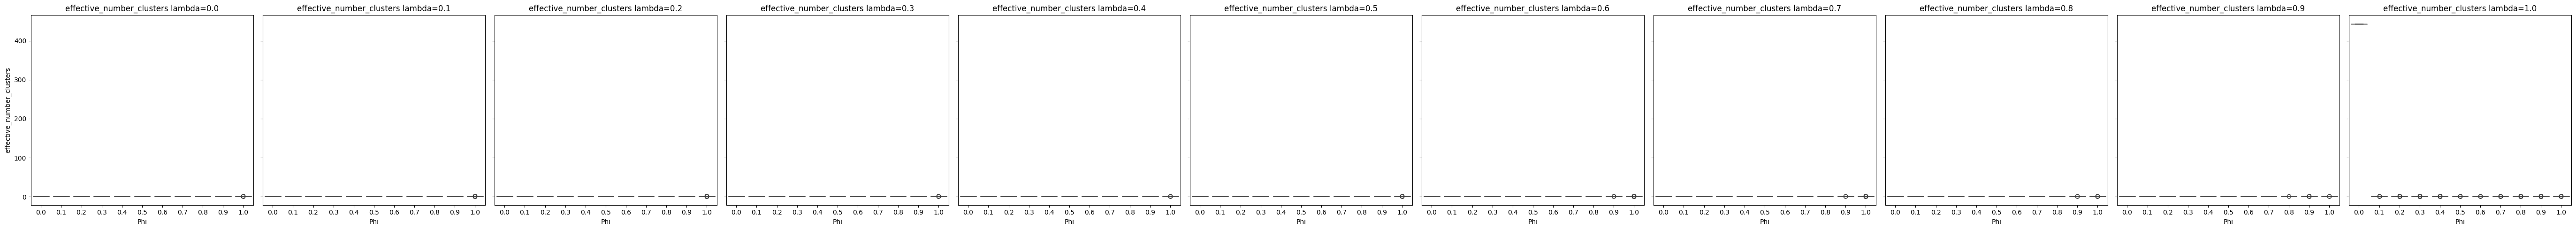

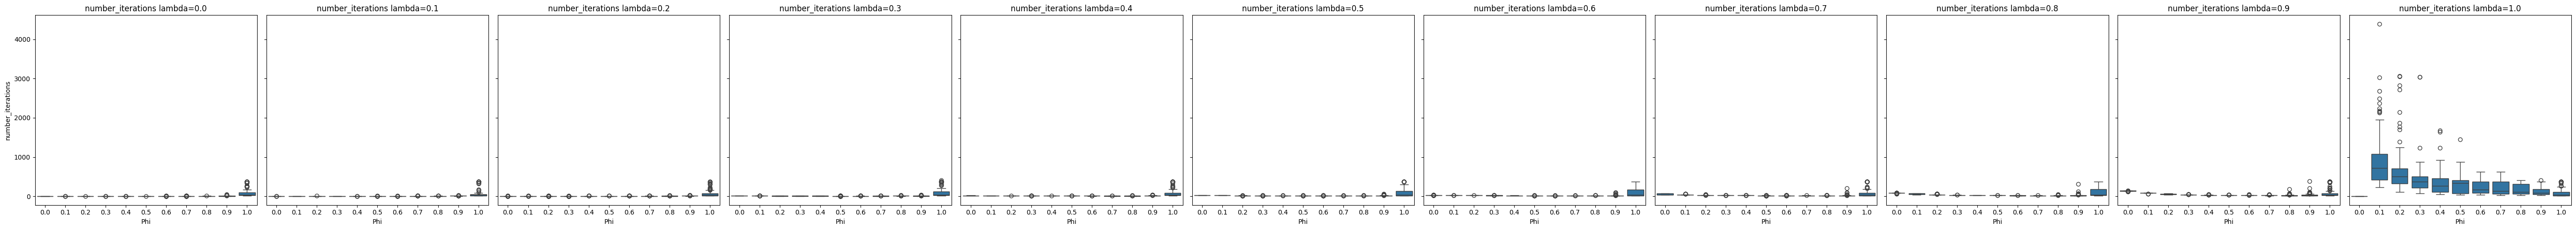

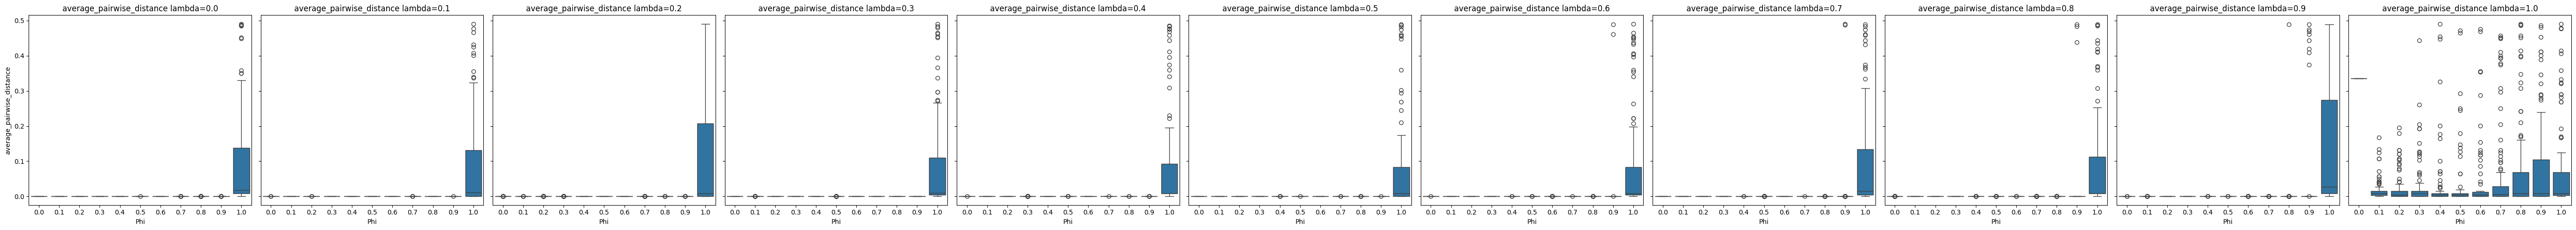

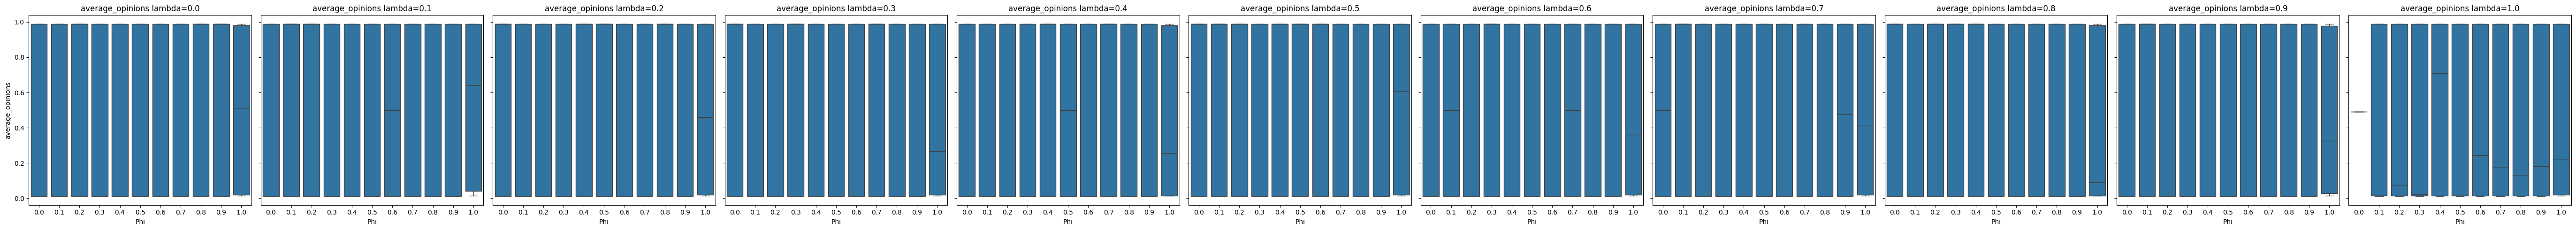

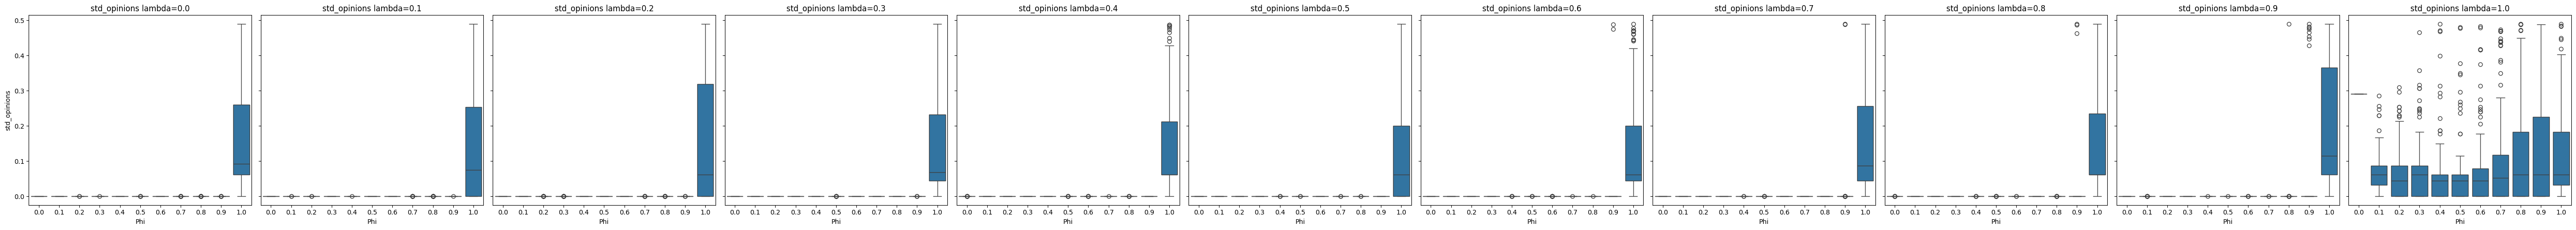

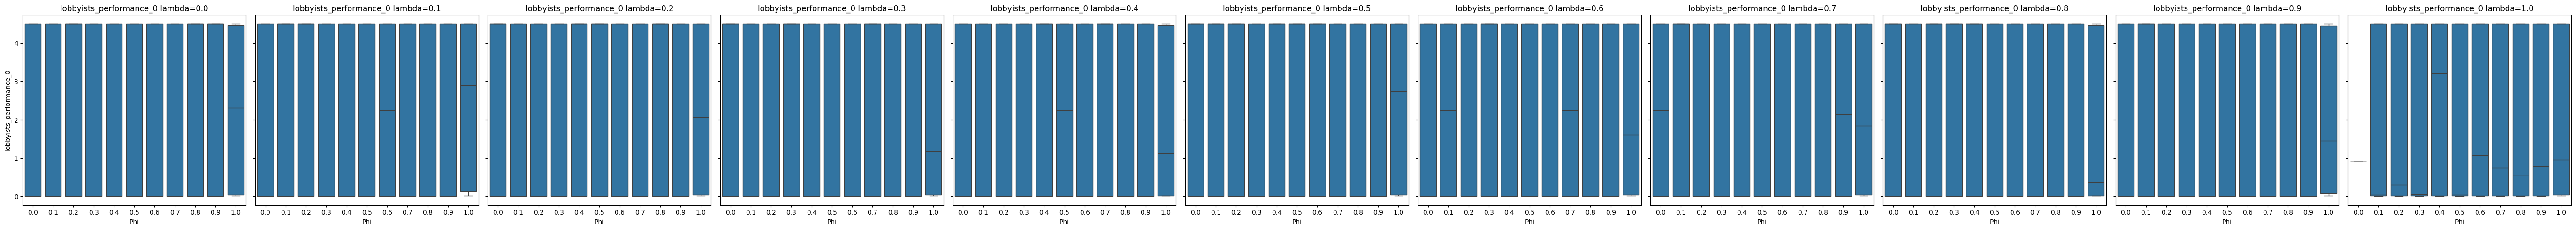

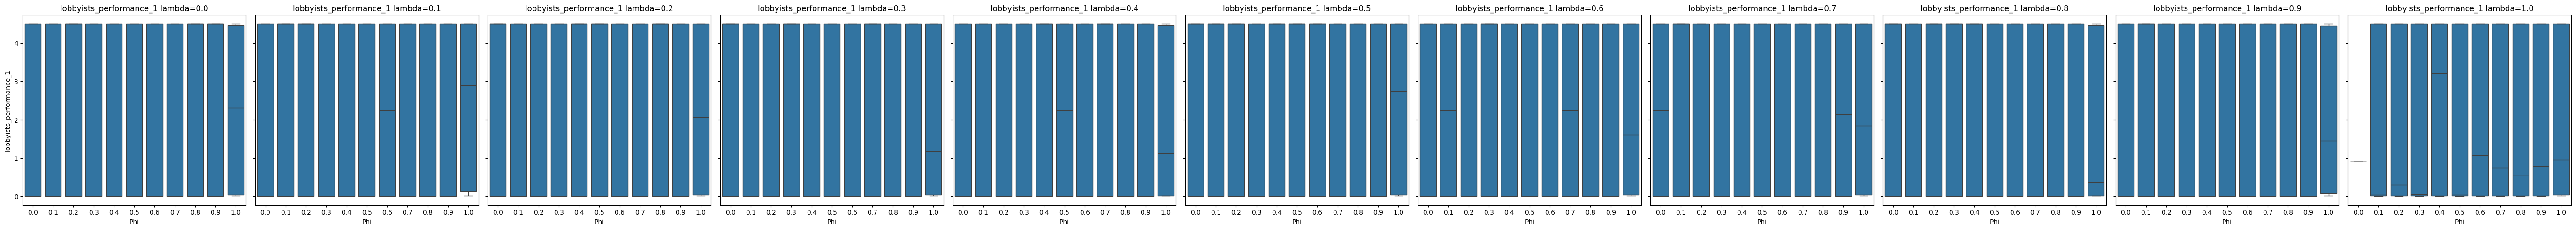

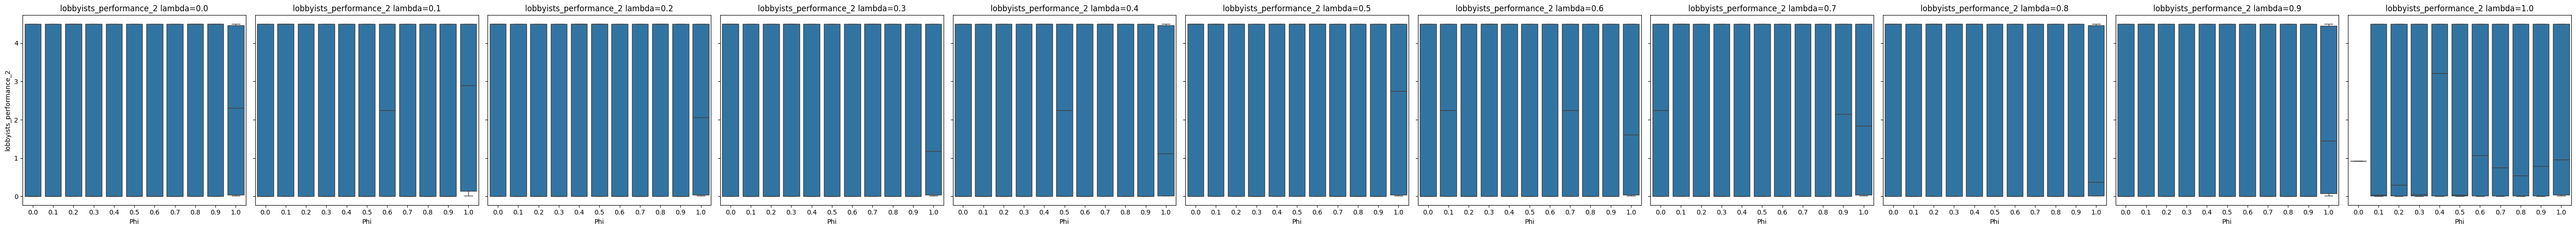

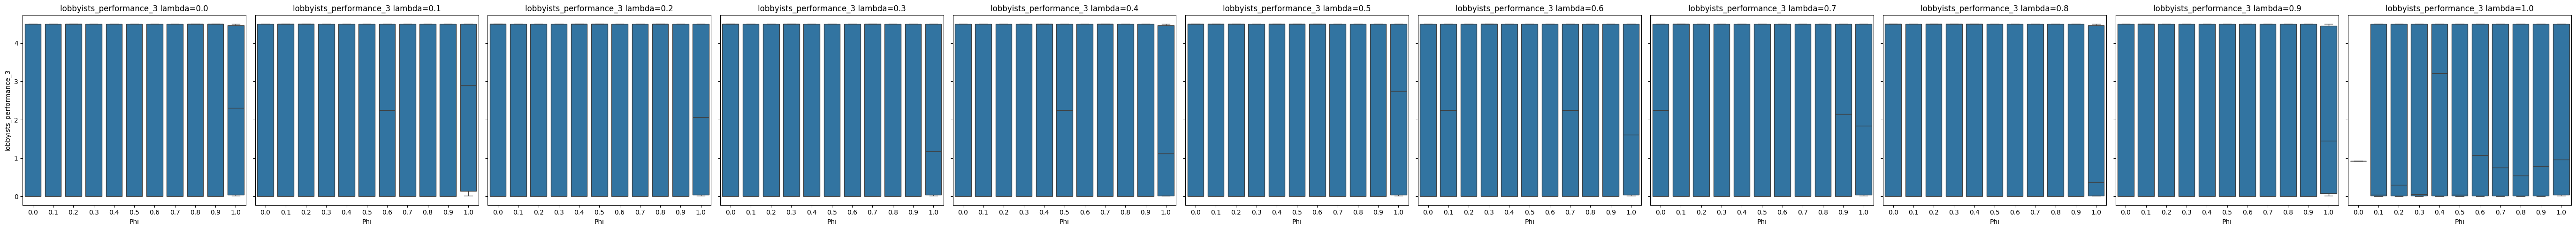

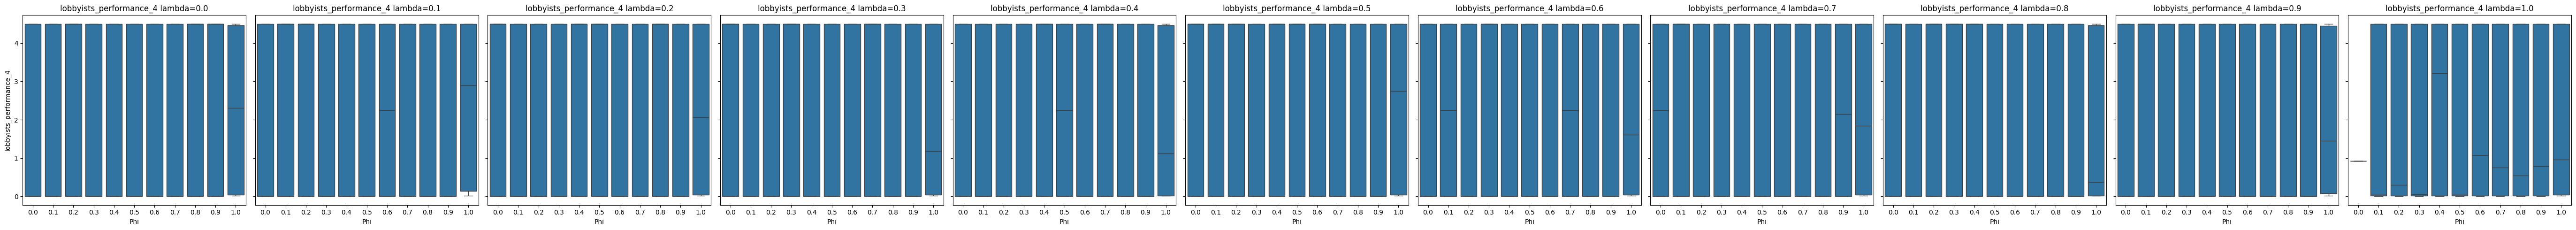

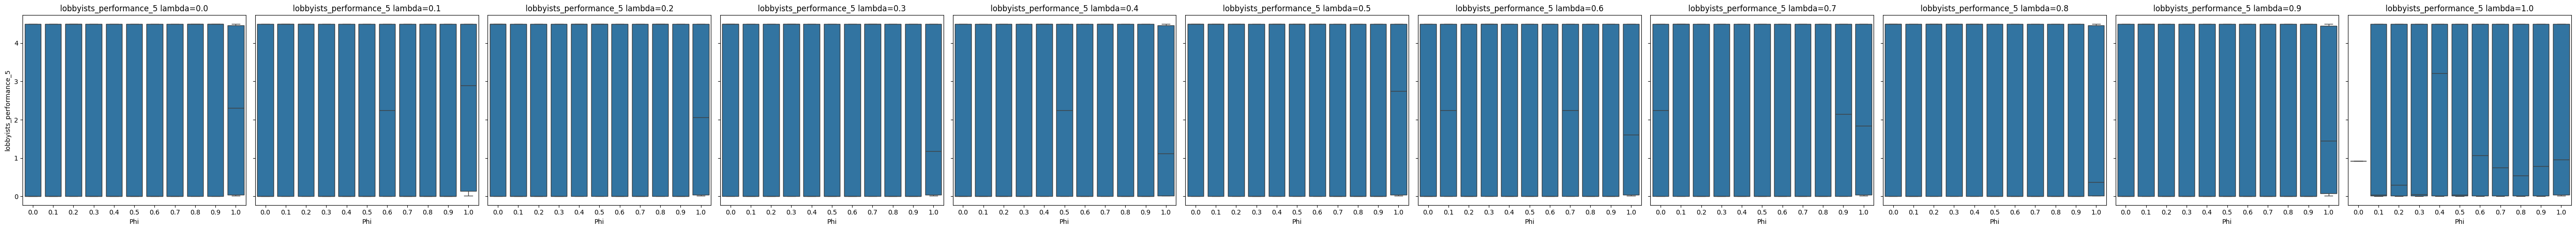

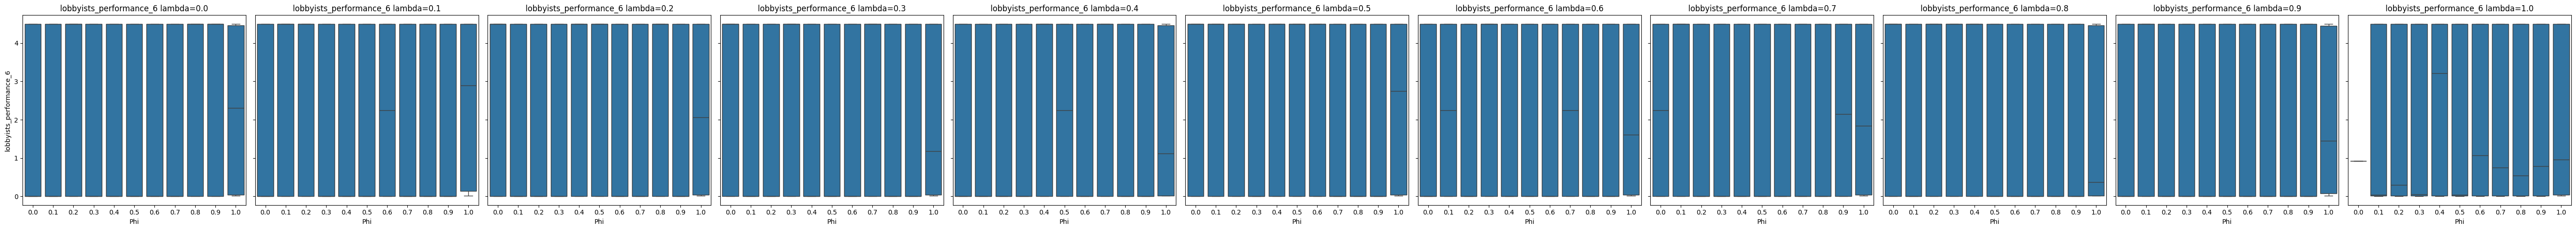

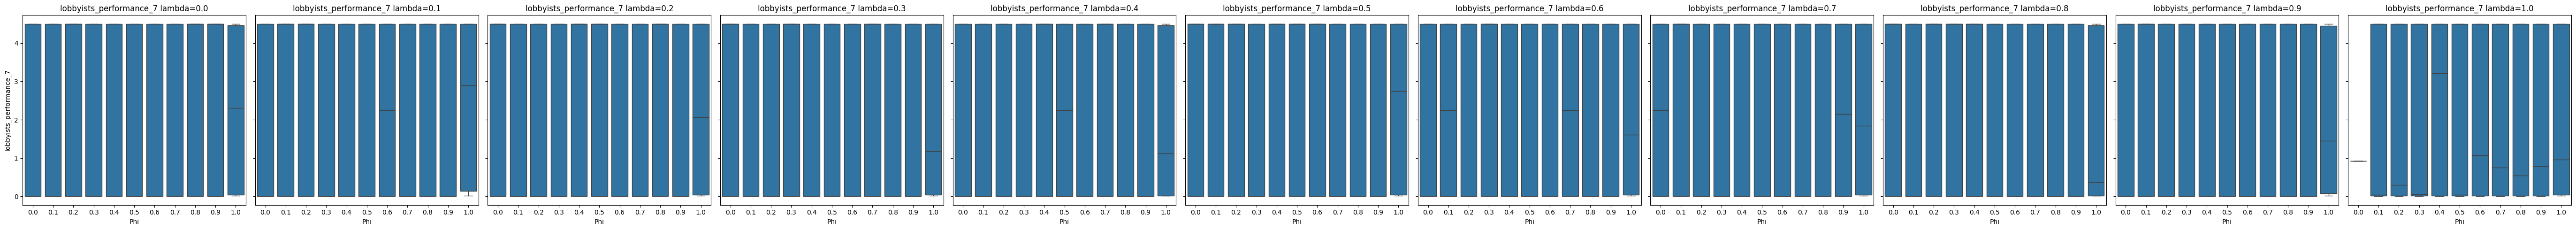

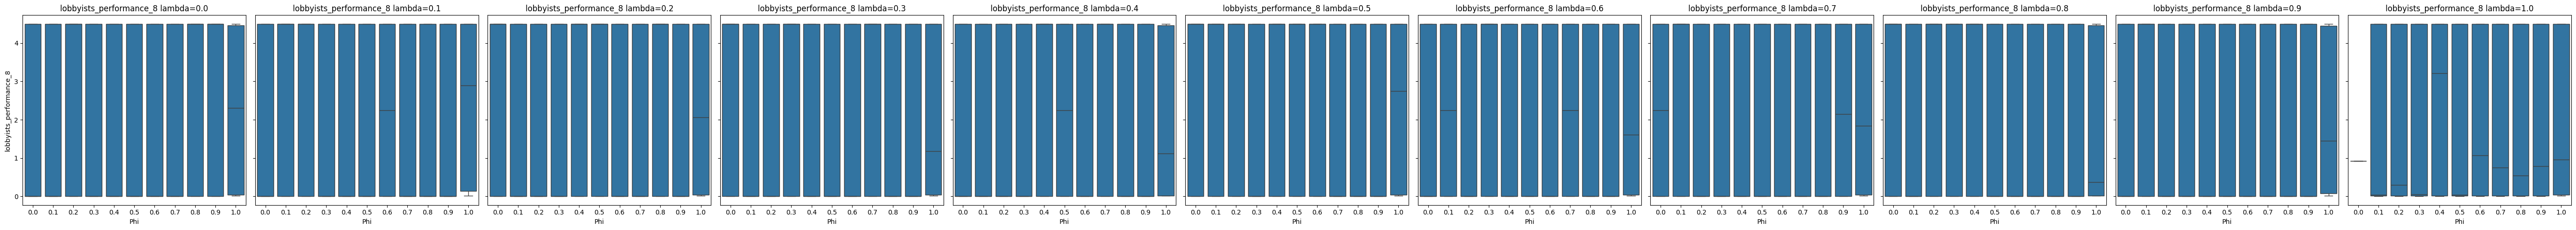

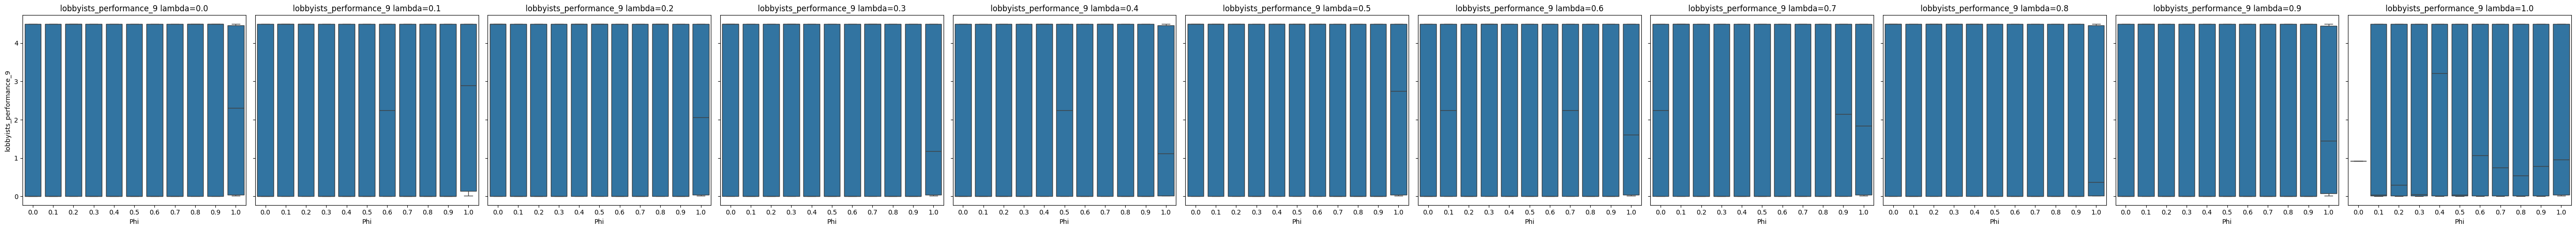

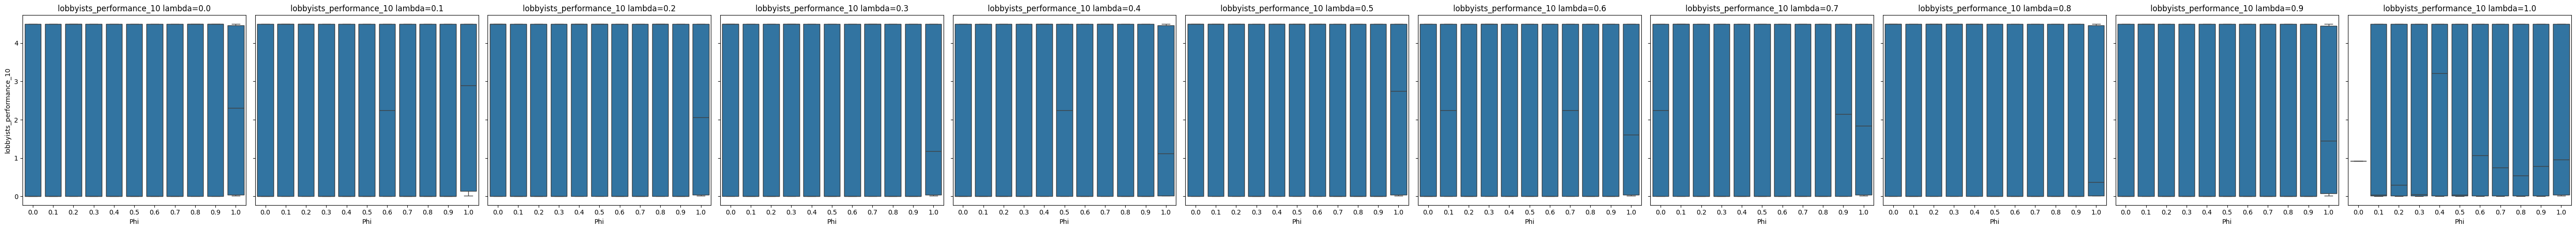

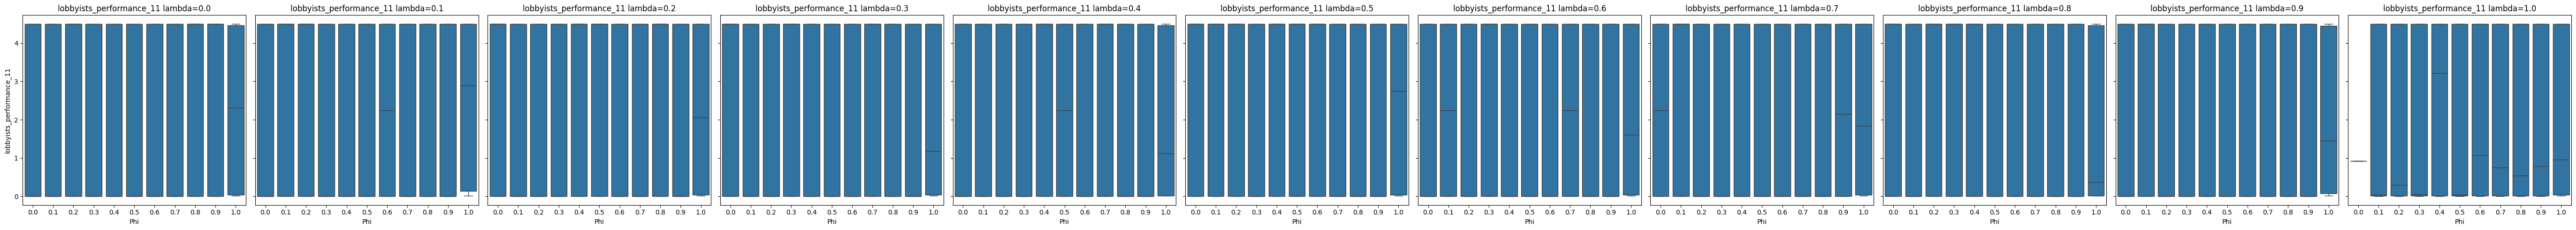

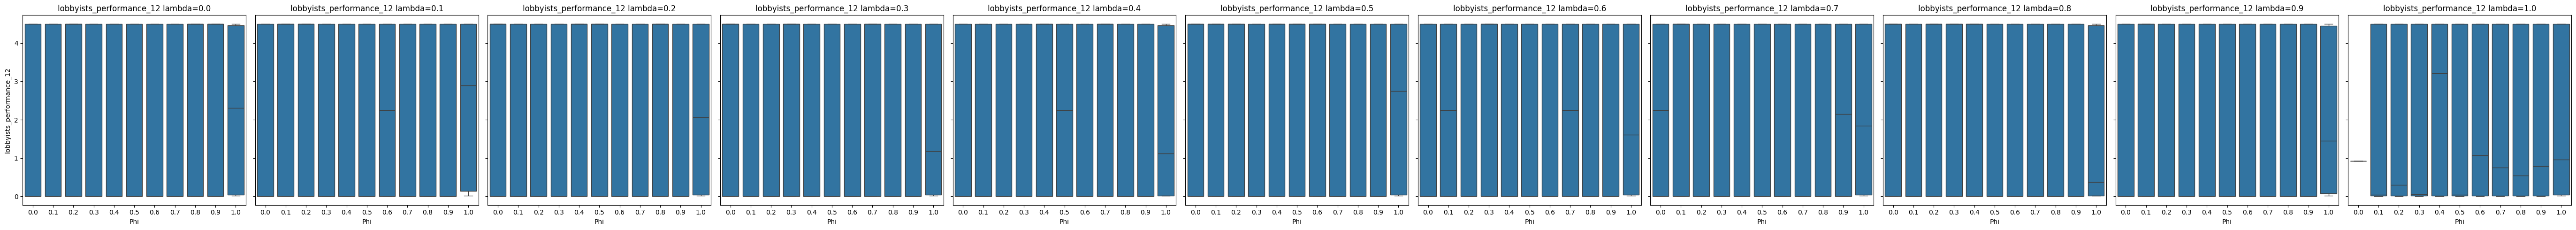

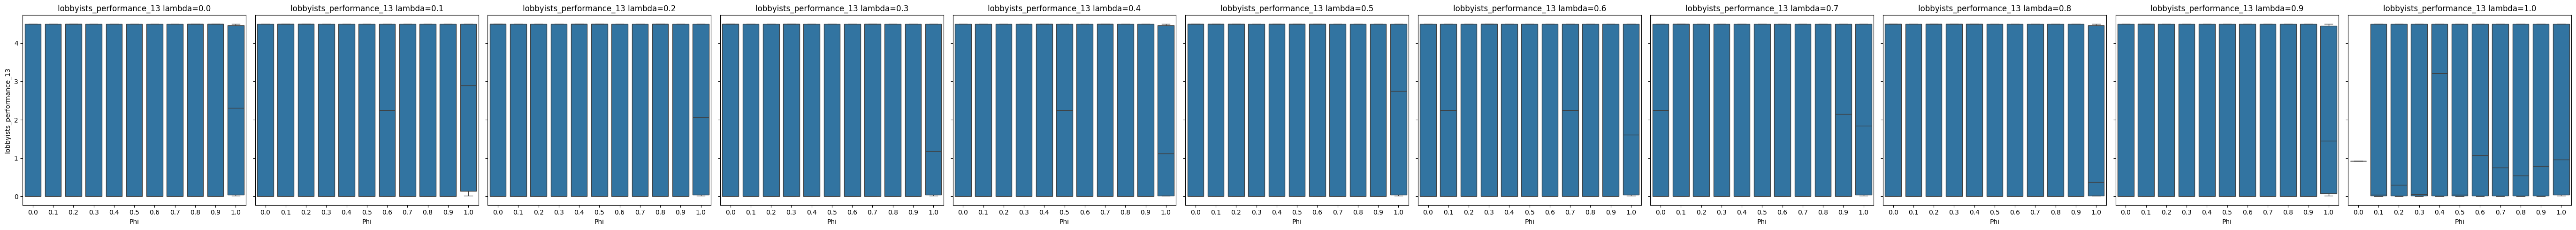

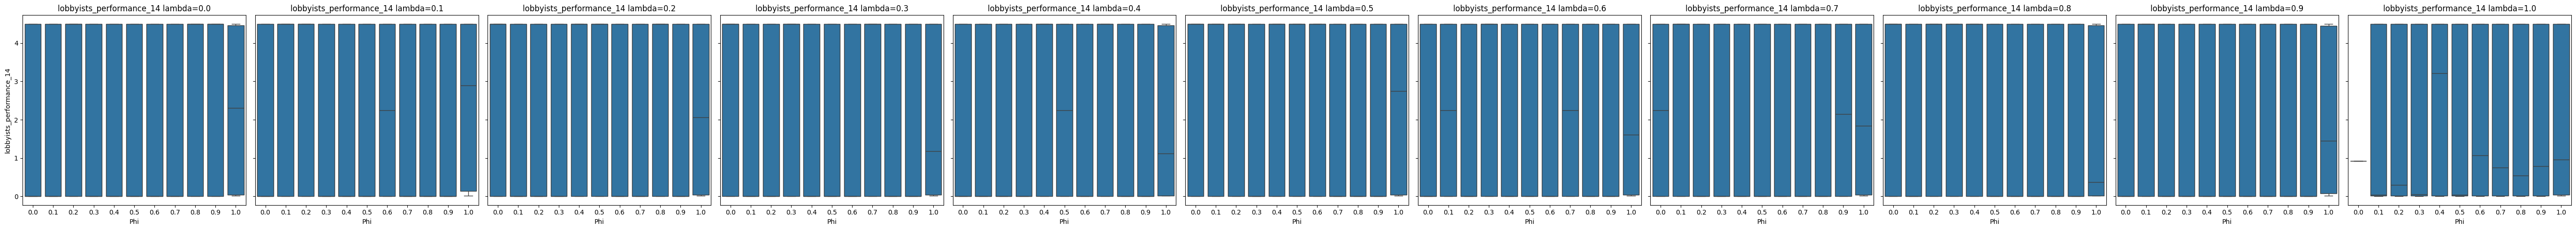

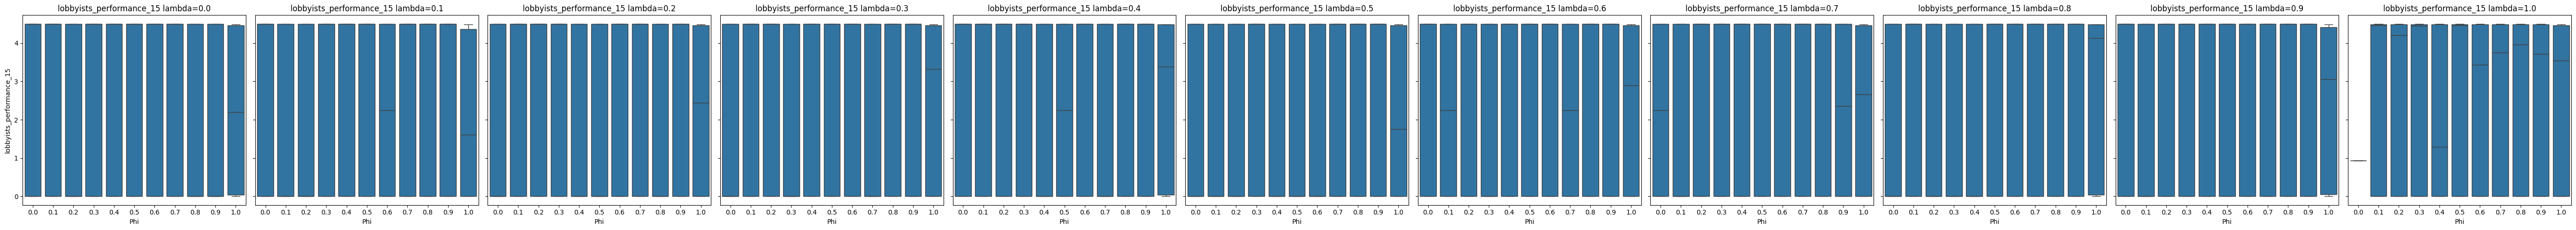

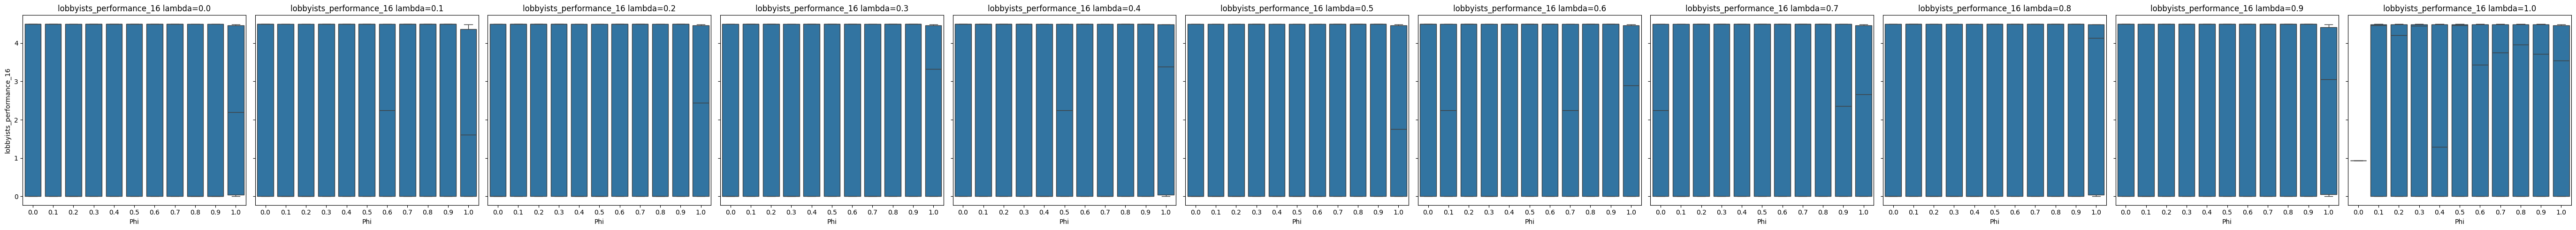

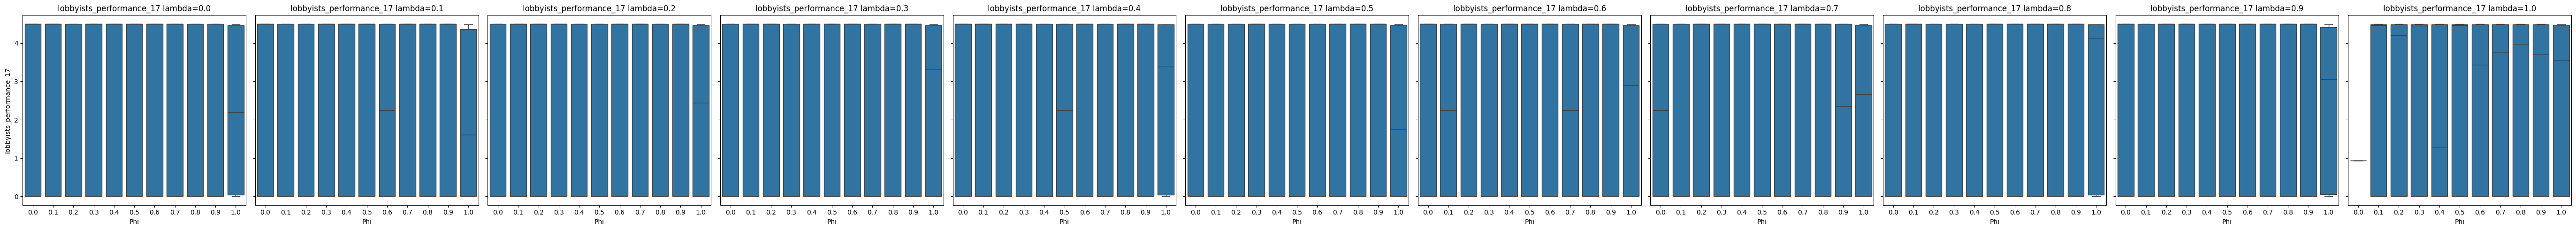

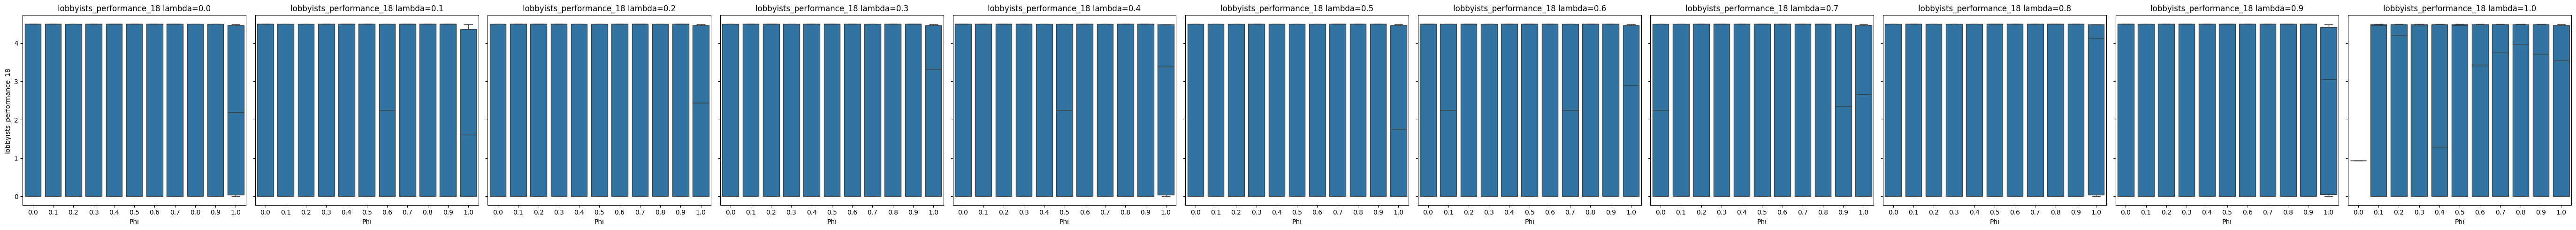

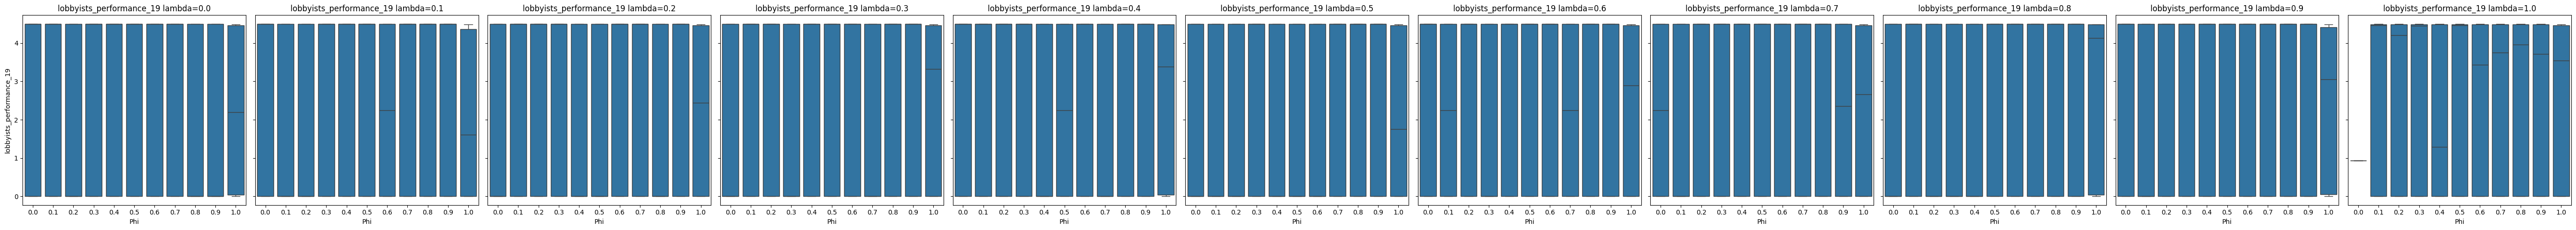

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def explode_lists(df):
    """Expands list values into separate rows while keeping other columns unchanged."""
    id_vars = ["kind", "lambda", "phi"]
    value_vars = [col for col in df.columns if col not in id_vars]
    
    exploded_data = []
    for _, row in df.iterrows():
        max_len = max(len(row[col]) for col in value_vars)
        for i in range(max_len):
            exploded_row = {col: row[col] if col in id_vars else row[col][i] for col in df.columns}
            exploded_data.append(exploded_row)
    
    return pd.DataFrame(exploded_data)

def plot_metrics_grid(df):
    df = explode_lists(df)
    metrics = [col for col in df.columns if col not in ["kind", "lambda", "phi"]]
    lambda_values = sorted(df["lambda"].unique())
    num_lambdas = len(lambda_values)
    
    kind = 'probabilities'
    df_kind = df[df["kind"] == kind]
    for metric in metrics:
        fig, axes = plt.subplots(1, num_lambdas, figsize=(5 * num_lambdas, 5), sharey=True)
        
        if num_lambdas == 1:
            axes = [axes]  # Ensure axes is iterable if only one lambda value exists
        
        for i, lambd in enumerate(lambda_values):
            ax = axes[i]
            subset = df_kind[df_kind["lambda"] == lambd]
            
            sns.boxplot(x="phi", y=metric, data=subset, ax=ax)
            ax.set_title(f"{metric} lambda={lambd}")
            ax.set_xlabel("Phi")
            ax.set_ylabel(metric)
        
        plt.tight_layout()
        figpath = os.path.join(basepath, 'figures')
        os.makedirs(figpath, exist_ok=True)
        figname = os.path.join(figpath, f'boxplots_{metric}.png')
        plt.savefig(figname, dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        plt.close()

# Example usage
#df = pd.read_csv(datapath)  # Load the DataFrame from CSV or other sources
plot_metrics_grid(df)
